/opt/homebrew/lib/python3.9/site-packages/matplotlib/cbook/__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


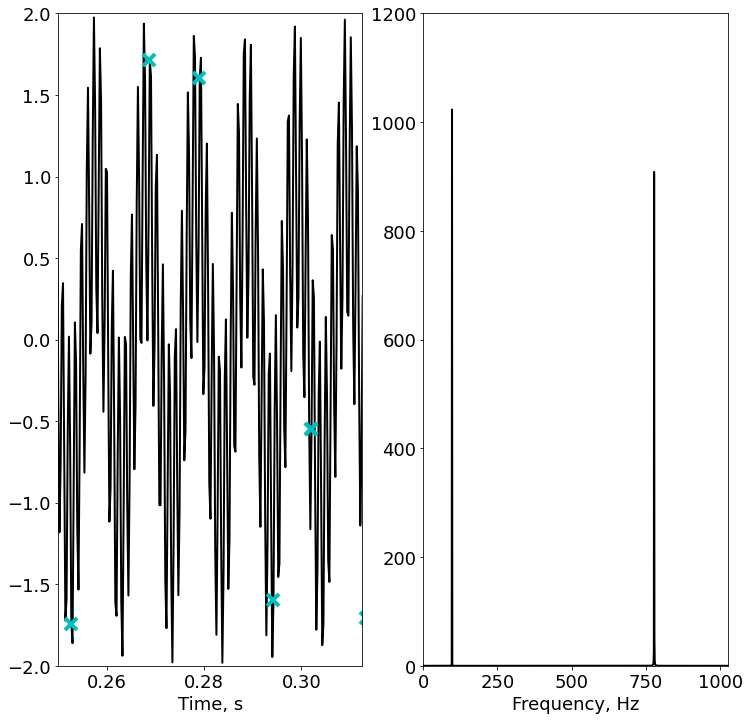

In [4]:
"""
Example of Steve Brunton's demonstration on undetermined compressed sensing problems.
This example demonstrates how you can beat the Shannon-Nyquist sampling rate with compressed sensing
if the signal's composition is inherently sparse and samples are taken randomly.
https://www.youtube.com/watch?v=5-LY6wBIKx8&list=PLMrJAkhIeNNRHP5UA-gIimsXLQyHXxRty&index=10
"""

import numpy as np
import matplotlib.pyplot as plt
import os, sys
from scipy.fftpack import dct, idct  # Discrete Cosine Transformation
from scipy.optimize import minimize
sys.path.append(os.path.join('..', 'UTILS'))

# Cosamp function https://github.com/avirmaux/CoSaMP/blob/master/cosamp.ipynb
def cosamp(phi, u, s, epsilon=1e-10, max_iter=1000):
    """
    Return an `s`-sparse approximation of the target signal
    Input:
        - phi, sampling matrix
        - u, noisy sample vector
        - s, sparsity
    """
    a = np.zeros(phi.shape[1])
    v = u
    it = 0 # count
    halt = False
    while not halt:
        it += 1
        print("Iteration {}\r".format(it), end="")
        
        y = np.dot(np.transpose(phi), v)
        omega = np.argsort(y)[-(2*s):] # large components
        omega = np.union1d(omega, a.nonzero()[0]) # use set instead?
        phiT = phi[:, omega]
        b = np.zeros(phi.shape[1])
        # Solve Least Square
        b[omega], _, _, _ = np.linalg.lstsq(phiT, u)
        
        # Get new estimate
        b[np.argsort(b)[:-s]] = 0
        a = b
        
        # Halt criterion
        v_old = v
        v = u - np.dot(phi, a)

        halt = (np.linalg.norm(v - v_old) < epsilon) or \
            np.linalg.norm(v) < epsilon or \
            it > max_iter
        
    return a

plt.rcParams['figure.figsize'] = [12, 12]
plt.rcParams.update({'font.size': 18})

# Generate signal and its DCT
n = 4096
t = np.linspace(0, 1, n)
x = np.cos(2*97*np.pi*t) + np.cos(2*777*np.pi*t)  # Derived 2-tone signal
xt = np.fft.fft(x)  # Fourier-transformed signal
PSD = xt * np.conj(xt) / n  # Power spectral density

# Randomly sample signal
p = 128 # Number of random samples, p = n/32
perm = np.floor(np.random.rand(p) * n ).astype(int)
y = x[perm]

# Plot the results
time_window = np.array((1024, 1280))/4096
freq = np.arange(n)
L = int(np.floor(n/2))

fig, axs = plt.subplots(1, 2)
axs = axs.reshape(-1)

axs[1].plot(freq[:L], PSD[:L], color='k', linewidth=2)
axs[1].set_xlim(0, 1024)
axs[1].set_ylim(0, 1200)
axs[1].set_xlabel('Frequency, Hz')

axs[0].plot(t, x, color='k', linewidth=2)
axs[0].plot(perm/n, y, color='r', marker='x', linewidth=0, ms=12, mew=4)
axs[0].set_xlim(time_window[0], time_window[1])
axs[0].set_ylim(-2, 2)
axs[0].set_xlabel('Time, s')

plt.show()